In [ ]:
import os
import math
import argparse
import itertools
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn import metrics

import utils
from datasets import Data, TransformerDataset
from models import FullyConnectedNetwork, PositionalEncoding

# Argument parser
# parser = argparse.ArgumentParser(description='Transformer Training Script')
# parser.add_argument('--output_dir', type=str, default='even', help='Specify a directory (to be created) for outputs')
# args = parser.parse_args()

# output_dir = args.output_dir
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

N = int(1e4)
batch_size = 100
n_epochs = 50

print(f'Using {output_dir} numbered events for training')
print(f'Batch size: {batch_size}')
print('Taking N =', N, ' random events')

# get the device
device = utils.getDevice()
print(f"Using {device} device")

# get the data files
bamboo_results_dir = '../output/DYestimation-v1.2.8-3/results/'
rootFiles = os.listdir(bamboo_results_dir)


def listFiles(prefix):
    return [f'{bamboo_results_dir}{file}' for file in rootFiles if any(p in file for p in prefix)]


data_files = listFiles(['EGamma', 'Muon'])

print('Number of Data root files:', len(data_files))

treenames = [
    'DL_boosted_mumu_skim;1',
    'DL_boosted_ee_skim;1',
    'DL_resolved_mumu_skim;1',
    'DL_resolved_ee_skim;1'
]

# The variables for each object
input_features = {
    'l1': ['l1_pt', 'l1_eta', 'l1_phi', 'l1_E'],
    'l2': ['l2_pt', 'l2_eta', 'l2_phi', 'l2_E'],
}

n_features = sum([len(val) for val in input_features.values()])

print('Number of input features:', n_features)

lepton_feat_dim = len(input_features['l1'])

assert lepton_feat_dim == len(input_features['l2'])

data_Data = Data(
    name='Data',
    files=data_files,
    treenames=treenames,
    N=N
)

data_set = [data_Data]

for data in data_set:
    print(f'{data.name} : {data["event_no"].shape[0]} events')

branches = list(itertools.chain.from_iterable(
    list(input_features.values())))

# Need to call them to load into memory
for data in data_set:
    start = time()
    for br in branches:
        data[br]
    print(f'Time passed loading {data.name} files:',
          round(time()-start, 2), 'seconds')


# Make pandas dataframes out of the data
# we're using `sample` to shuffle the data since using all of data is
# computationally expensive and we want to take a really random subset
df = pd.concat([data.get_df.sample(n=min(N, len(data.get_df)))
               for data in data_set])


Using outputs numbered events for training
Batch size: 100
Taking N = 10000  random events
Using cuda device
Number of Data root files: 16
Number of input features: 8
Tree DL_boosted_mumu_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/__skeleton__Muon_Run2022C.root
Tree DL_boosted_ee_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/__skeleton__Muon_Run2022C.root
Tree DL_resolved_mumu_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/__skeleton__Muon_Run2022C.root
Tree DL_resolved_ee_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/__skeleton__Muon_Run2022C.root
Tree DL_boosted_ee_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/Muon_Run2022E.root
Tree DL_boosted_ee_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/MuonEG_Run2022F.root
Tree DL_boosted_ee_skim;1 is not in file ../output/DYestimation-v1.2.8-3/results/Muon_Run2022C.root
Tree DL_boosted_ee_skim;1 is not in file ../output/DYestimation-v1.2.8-3/resu

In [2]:
df

,file,tree,sample,event_no,l1_pt,l1_eta,l1_phi,l1_E,l2_pt,l2_eta,l2_phi,l2_E
74502,../output/DYestimation-v1.2.8-3/results/EGamma...,DL_resolved_ee_skim,EGamma_Run2022G.root,1945316373,85.763016,-1.139160,2.351074,147.693817,27.426355,-1.407959,-0.432983,59.408863
8341,../output/DYestimation-v1.2.8-3/results/Muon_R...,DL_resolved_mumu_skim,Muon_Run2022E.root,456774792,53.591015,2.066742,-2.200317,215.051224,43.848011,0.930016,2.421326,64.217613
83575,../output/DYestimation-v1.2.8-3/results/EGamma...,DL_boosted_ee_skim,EGamma_Run2022C.root,196383034,253.334869,-0.303345,2.023438,265.080200,39.372208,-0.480774,1.085205,44.010849
38288,../output/DYestimation-v1.2.8-3/results/Muon_R...,DL_boosted_mumu_skim,Muon_Run2022F.root,330395033,43.976017,-1.302841,-2.377869,86.885574,33.212959,-0.000807,1.012466,33.213139
65855,../output/DYestimation-v1.2.8-3/results/Muon_R...,DL_resolved_mumu_skim,Muon_Run2022D.root,243811591,46.431492,-1.578186,0.087400,117.297737,28.694904,-0.175808,-3.138580,29.139698
...,...,...,...,...,...,...,...,...,...,...,...,...
32498,../output/DYestimation-v1.2.8-3/results/Muon_R...,DL_boosted_mumu_skim,Muon_Run2022F.root,939544444,226.104492,1.255692,0.060730,429.049500,16.299194,1.242645,1.973465,30.588770
49235,../output/DYestimation-v1.2.8-3/results/Muon_R...,DL_resolved_mumu_skim,Muon_Run2022F.root,499404070,80.929039,0.136292,1.859634,81.681908,42.007465,0.676712,-2.805786,51.998711
31119,../output/DYestimation-v1.2.8-3/results/Muon_R...,DL_boosted_mumu_skim,Muon_Run2022F.root,1114337574,138.995880,1.508850,3.018463,329.607391,89.056389,1.039124,-2.575775,141.622101
112219,../output/DYestimation-v1.2.8-3/results/EGamma...,DL_resolved_ee_skim,EGamma_Run2022E.root,165240208,75.575272,-1.382324,-1.134521,160.036133,61.453430,-1.218750,-2.490723,113.029938


In [3]:
# add dummy weight col for now
df['weight'] = 1

In [4]:
# Check for infinite or nan values
inf_indices = df.index[df.isin([np.inf, -np.inf]).any(axis=1)].tolist()
nan_indices = df.index[df.isna().any(axis=1)].tolist()

n_infs = len(inf_indices)
n_nans = len(nan_indices)

if n_infs > 0:
    print(f'Found {n_infs} row(s) that have infinite values in the dataframe.')
    print('Here are them: ', df.iloc[inf_indices])
    print('Removing them.')
    df = df.drop(inf_indices)


if n_nans > 0:
    print(f'Found {n_nans} row(s) that have NaN values in the dataframe.')
    print('Here are the them: ', df.iloc[nan_indices])
    print('Removing them.')
    df = df.drop(nan_indices)

In [5]:
# Split the data into training and validation sets

train_df, valid_df = train_test_split(df, train_size=0.8, shuffle=True)

weight_branch = 'weight'

dataset_train = TransformerDataset(
    df=train_df,
    variable_sets=list(input_features.values()),
    device=device,
)
dataset_test = TransformerDataset(
    df=valid_df,
    variable_sets=list(input_features.values()),
    device=device,
)

# DataLoader
train_dataloader = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    shuffle=False
)

print(
    f'Training set   = {len(dataset_train)} events ({len(train_dataloader)} batches)')
print(
    f'Validation set = {len(dataset_test)} events ({len(test_dataloader)} batches)')

Training set   = 8000 events (80 batches)
Validation set = 2000 events (20 batches)


In [6]:
for batch in train_dataloader:
    print(batch)
    break

tensor([[[ 5.8941e+01,  1.5628e-01,  2.4579e+00,  5.9663e+01],
         [ 3.5295e+01,  9.7728e-01, -1.5186e+00,  5.3534e+01]],

        [[ 5.6003e+01,  1.8527e-01,  3.0268e+00,  5.6967e+01],
         [ 3.6611e+01, -1.5084e-01, -2.8020e-01,  3.7028e+01]],

        [[ 1.2302e+02, -3.0743e-01,  1.5847e+00,  1.2888e+02],
         [ 2.9311e+01, -5.0281e-01, -3.0439e+00,  3.3095e+01]],

        [[ 9.3765e+01, -6.5895e-01, -2.0296e+00,  1.1487e+02],
         [ 1.8616e+01, -1.6455e+00,  1.1991e+00,  5.0044e+01]],

        [[ 1.7998e+02, -1.9604e+00,  3.0103e+00,  6.5182e+02],
         [ 9.2963e+01, -1.7173e+00,  2.3325e+00,  2.6722e+02]],

        [[ 1.3051e+02, -1.0174e+00,  1.4788e-01,  2.0408e+02],
         [ 4.5074e+01, -1.5249e+00,  1.3298e+00,  1.0846e+02]],

        [[ 5.7117e+01, -2.9669e-02,  3.0410e+00,  5.7142e+01],
         [ 3.0549e+01, -1.0191e+00, -7.2161e-01,  4.7834e+01]],

        [[ 1.5708e+02,  1.2205e+00,  2.6025e+00,  2.8933e+02],
         [ 1.4930e+02,  1.5806e+00,  3.08

In [ ]:
# Transformer-based Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim=4, model_dim=128, nhead=16, num_layers=3):
        super().__init__()
        self.embedding = FullyConnectedNetwork(input_dim, model_dim)
        # self.pos_enc = PositionalEncoding(model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.latent_proj = nn.Linear(model_dim * 2, model_dim)  # combine two leptons

        self.decoder_input = nn.Linear(model_dim, model_dim * 2)
        self.decoder = nn.Sequential(
            nn.Linear(model_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * input_dim)  # outputs 2 leptons × 4 features
        )

    def forward(self, x):
        # x shape: (batch, 2, 4)
        x = self.embedding(x)          # (batch, 2, model_dim)
        # x = self.pos_enc(x)
        x = self.encoder(x)            # (batch, 2, model_dim)
        x = x.view(x.size(0), -1)      # (batch, 2*model_dim)
        z = self.latent_proj(x)        # (batch, model_dim)

        dec_input = self.decoder_input(z)
        out = self.decoder(dec_input)
        out = out.view(-1, 2, 4)       # (batch, 2, 4)
        return out

In [8]:
model = TransformerAutoencoder().to(device)

In [9]:
# activation_function = nn.ReLU
# discriminator_model = TransformerClassifier(input_features, num_heads=4, embed_dim=512, hidden_dim=512, num_classes=1, activation_function=activation_function)

In [10]:
# Hyperparameters
embed_dim = 64
num_heads = 16
hidden_dim = 256
learning_rate = 1e-4
activation_function = nn.ReLU

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

# loss_fn = utils.WeightedLoss(nn.MSELoss)
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode='min', patience=5, factor=0.5, threshold_mode='abs', eps=1e-6)


early_stopping = utils.EarlyStopping(patience=6, delta=1e-6)


def train(model, dataloader, loss_function, optimizer, training_loss, LR=[]):
    n_batches = len(dataloader)
    lr = optimizer.param_groups[0]['lr']
    LR.append(lr)
    model.train()
    epoch_loss_sum = 0.0
    for batch in dataloader:
        x = batch
        y = model(x)
        batch_loss = loss_function(y, x)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        epoch_loss_sum += batch_loss.item()
    avg_loss = epoch_loss_sum / n_batches
    training_loss.append(avg_loss)


def validate(model, dataloader, loss_function, scheduler, avg_val_loss):
    n_batches = len(dataloader)
    model.eval()
    val_loss_sum = 0.0
    with torch.no_grad():
        for batch in dataloader:
            x = batch
            y = model(x)
            val_loss_sum += (loss_function(y, x)).item()
    avg_epoch_loss = val_loss_sum / n_batches
    avg_val_loss.append(avg_epoch_loss)
    scheduler.step(avg_epoch_loss)

steps_per_epoch = math.ceil(len(dataset_train) / train_dataloader.batch_size)

# metrics
avg_val_loss = []
training_loss = []
learning_rate = []

# training and validation loop
for i in tqdm(range(n_epochs)):
    train(model, train_dataloader, loss_function=loss_fn,
          optimizer=optimizer, training_loss=training_loss, LR=learning_rate)
    validate(model, test_dataloader, loss_function=loss_fn, scheduler=scheduler,
             avg_val_loss=avg_val_loss)
    if early_stopping(avg_val_loss, learning_rate):
        print(f'Early stopping at epoch: {i+1}')
        break

print("Training complete!")



100%|██████████| 50/50 [01:29<00:00,  1.78s/it]

Training complete!


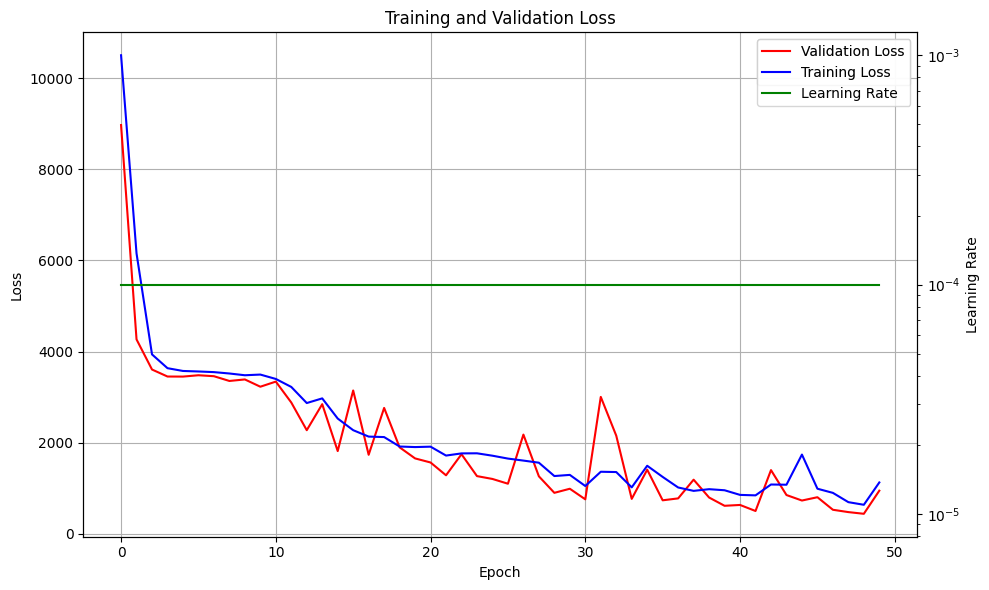

Loss and LR plotted
Saved model to outputs/model.onnx
Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                    ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add                │ 21             │ 18               │
│ Cast               │ 12             │ 0                │
│ Concat             │ 31             │ 4                │
│ Constant           │ 216            │ 70               │
│ Div                │ 6              │ 0                │
│ Gather             │ 25             │ 10               │
│ Gemm               │ 7              ��� 7                │
│ LayerNormalization │ 9              │ 9                │
│ MatMul             │ 18             │ 18               │
│ Mod                │ 3              │ 0                │
│ Mul                │ 12             │ 6                │
│ Relu               │ 7              │ 7                │
│ Reshape   

0

In [11]:
# Create a figure for plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the training and validation loss
ax.plot(avg_val_loss, color='red', label='Validation Loss')
ax.plot(training_loss, color='blue', label='Training Loss')
ax.grid(True)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()

# Add a secondary y-axis for learning rate
ax2 = ax.twinx()
ax2.plot(learning_rate, color='green', label='Learning Rate')
ax2.set_yscale('log')
ax2.set_ylabel('Learning Rate')

# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()
fig.savefig(f'{output_dir}/loss_and_LR.png')

print('Loss and LR plotted')

dummy_input = torch.randn(1, 2, 4).to(device)

dynamic_axes = {}
for item in input_features.keys():
    dynamic_axes[item] = {0: 'dynamic_size'}
dynamic_axes['output'] = {0: 'dynamic_size'}

onnx_output = torch.onnx.export(
    model,
    dummy_input,
    f"{output_dir}/model.onnx",
    input_names=list(input_features.keys()),
    output_names=['output'],
    dynamic_axes=dynamic_axes)
print(f"Saved model to {output_dir}/model.onnx")


# simplify the onnx file
os.system(
    f'python -m onnxsim {output_dir}/model.onnx {output_dir}/model_simplified.onnx')


In [12]:
# Step 1: Collect all latent vectors from real data
all_latents = []
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.to(device)
        embedded = model.embedding(batch)
        encoded = model.encoder(embedded)
        flat = encoded.view(encoded.size(0), -1)
        latents = model.latent_proj(flat)
        all_latents.append(latents.cpu())
all_latents = torch.cat(all_latents, dim=0)  # shape: (N, latent_dim)

# Step 2: Resample from real latent vectors
num_samples = len(dataset_test)
indices = np.random.choice(all_latents.shape[0], size=num_samples, replace=True)
z_samples = all_latents[indices].to(device)

# Step 3: Decode
with torch.no_grad():
    dec_input = model.decoder_input(z_samples)
    generated = model.decoder(dec_input)
    generated_data = generated.view(-1, 2, 4)

In [13]:
generated_data

tensor([[[ 1.3289e+02, -7.0100e-02, -1.8726e-01,  3.5438e+02],
         [ 3.9409e+01, -3.6775e-01, -2.9971e-01,  6.5360e+01]],

        [[ 6.6692e+01,  2.0204e-02, -2.5982e-01,  1.0459e+02],
         [ 3.9625e+01, -1.3941e-01, -9.3260e-02,  8.1952e+01]],

        [[ 7.4944e+01,  2.6928e-03, -3.2377e-01,  1.2484e+02],
         [ 4.2224e+01, -1.9291e-01, -7.9869e-02,  8.4791e+01]],

        ...,

        [[ 7.3448e+01,  6.4726e-02, -2.2930e-01,  1.0901e+02],
         [ 4.6923e+01,  8.2869e-03, -1.8901e-01,  1.0776e+02]],

        [[ 8.2304e+01, -2.2578e-02, -2.5896e-01,  1.9188e+02],
         [ 3.0268e+01, -3.7526e-01, -1.1074e-01,  4.4765e+01]],

        [[ 8.9447e+01, -5.3317e-02, -3.0645e-01,  1.8070e+02],
         [ 4.1649e+01, -2.4988e-01, -6.9987e-02,  7.9023e+01]]],
       device='cuda:0')

In [14]:
def compute_mll(leptons):  
    """
    leptons: Tensor of shape (2, 4) with features (pT, eta, phi, E)
    Returns: Tensor of shape (1) with invariant mass
    """
    pT, eta, phi, E = leptons[:, 0], leptons[:, 1], leptons[:, 2], leptons[:, 3]
    
    px = pT * torch.cos(phi)
    py = pT * torch.sin(phi)
    pz = pT * torch.sinh(eta)

    E_tot = E[0] + E[1]
    px_tot = px[0] + px[1]
    py_tot = py[0] + py[1]
    pz_tot = pz[0] + pz[1]

    m2 = E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2)
    mll = torch.sqrt(torch.clamp(m2, min=1e-6))  # avoid negative sqrt
    return mll


In [15]:
lepton1_data = []
lepton1_gen = []
lepton2_data = []
lepton2_gen = []
mll_data = []
mll_gen = []
for batch in test_dataloader:
    for leptons in batch:
        lepton1_data.append([leptons[0].cpu().numpy()])
        lepton2_data.append([leptons[1].cpu().numpy()])
        mll_data.append(compute_mll(leptons).cpu().numpy())
for leptons in generated_data:
    lepton1_gen.append(leptons[0].cpu().numpy())
    lepton2_gen.append(leptons[1].cpu().numpy())
    mll_gen.append(compute_mll(leptons).cpu().numpy())


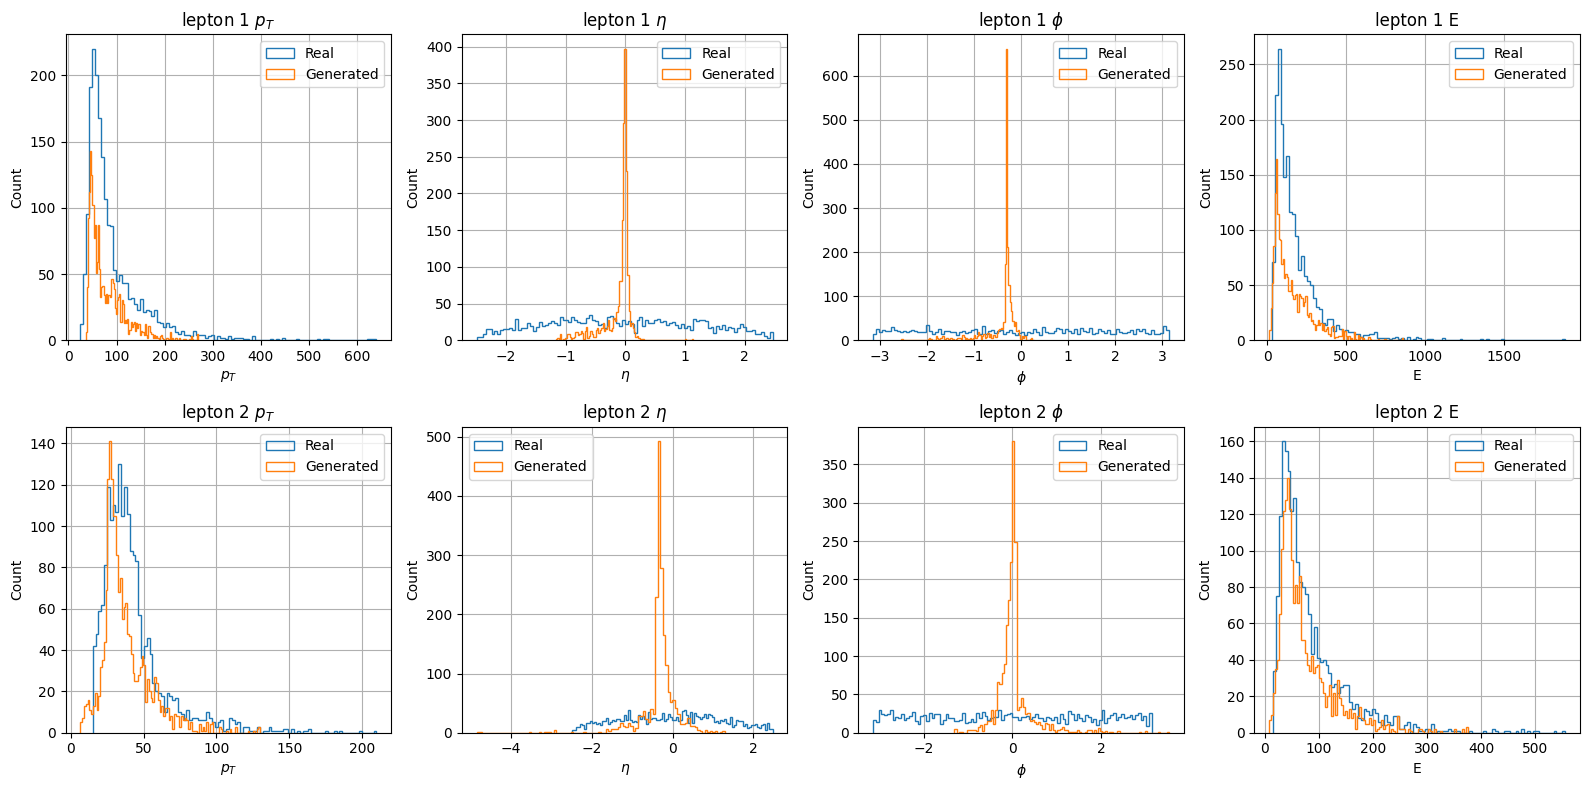

Saved feature comparison plot to outputs/feature_comparison.png


In [16]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

labels = ['$p_T$', '$\eta$','$\phi$', 'E']
for i in range(4):
    # Plot l1 comparison
    axes[0,i].hist([arr[0][i] for arr in lepton1_data], bins=100, histtype='step', label='Real')
    axes[0,i].hist([arr[i] for arr in lepton1_gen], bins=100, histtype='step', label='Generated')
    axes[0,i].set_xlabel(rf'{labels[i]}')
    axes[0,i].set_ylabel('Count')
    axes[0,i].legend()
    axes[0,i].set_title(rf'lepton 1 {labels[i]}')
    axes[0,i].grid(True)
    # Plot l2 comparison
    axes[1,i].hist([arr[0][i] for arr in lepton2_data], bins=100, histtype='step', label='Real')
    axes[1,i].hist([arr[i] for arr in lepton2_gen], bins=100, histtype='step', label='Generated')
    axes[1,i].set_xlabel(rf'{labels[i]}')
    axes[1,i].set_ylabel('Count')
    axes[1,i].legend()
    axes[1,i].set_title(rf'lepton 2 {labels[i]}')
    axes[1,i].grid(True)

plt.tight_layout()
plt.savefig(f'{output_dir}/feature_comparison.png')
plt.show()
print(f'Saved feature comparison plot to {output_dir}/feature_comparison.png')


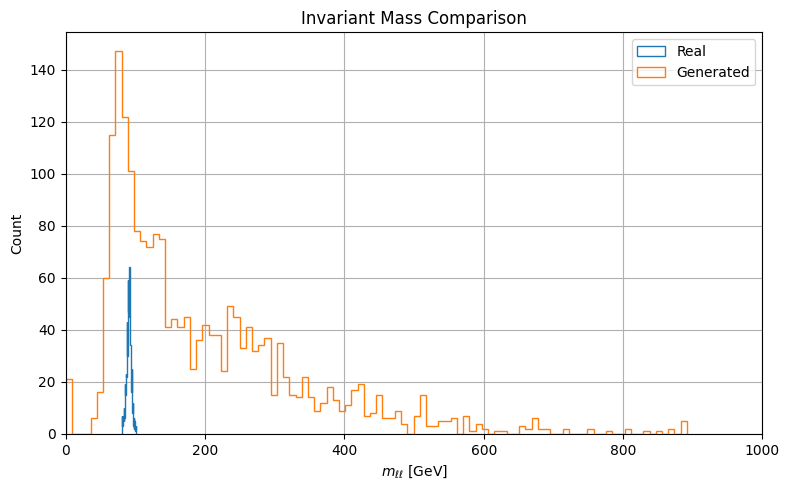

Saved mll comparison plot to outputs/mll_comparison.png


In [17]:
plt.figure(figsize=(8, 5))
plt.hist(mll_data, bins=100, histtype='step', label='Real')
plt.hist(mll_gen, bins=100, histtype='step', label='Generated')
plt.xlabel(r'$m_{\ell\ell}$ [GeV]')
plt.xlim(0,1000)
plt.ylabel('Count')
plt.legend()
plt.title('Invariant Mass Comparison')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{output_dir}/mll_comparison.png')
plt.show()
print(f'Saved mll comparison plot to {output_dir}/mll_comparison.png')